In [4]:
!pip install git+https://github.com/Shafi2016/pymodeltime.git


  Cloning https://github.com/Shafi2016/pymodeltime.git to /tmp/pip-req-build-_dbv06_f
  Running command git clone --filter=blob:none --quiet https://github.com/Shafi2016/pymodeltime.git /tmp/pip-req-build-_dbv06_f
  Resolved https://github.com/Shafi2016/pymodeltime.git to commit 069653b8d965cdc53364a3aabfd6f8098787669f
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.2/16.2 MB 34.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 47.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 57.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.2/265.2 MB 1.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 759.7/759.7 kB 35.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 20.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 9.9 MB/s eta

In [5]:
from pymodeltime import ArimaReg, ProphetReg
from pymodeltime import ModelTimeTable, ModelTimeAccuracy, ModelTimeCalibration, ModelTimeForecast,ModelTimeRefit
from pymodeltime import ArimaReg, ProphetReg
from pymodeltime import MLModelWrapper,H2OAutoMLWrapper
from pymodeltime import plot_modeltime_forecast
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")


In [6]:
import requests
import pandas as pd

url = 'https://raw.githubusercontent.com/Shafi2016/pymodeltime/main/data/data.csv'

response = requests.get(url)
open('data.csv', 'wb').write(response.content)

data = pd.read_csv('data.csv')
data = data[['id','date','value']]
print(data.head(3))


     id        date   value
0  M750  1990-05-01  6620.0
1  M750  1990-06-01  6690.0
2  M750  1990-07-01  6000.0


In [7]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(data, test_size=0.2, shuffle=False)

In [8]:
# Initialize and fit the ARIMA model
arima_reg_model_uni = ArimaReg(
    non_seasonal_ar=1,
    non_seasonal_differences=0,
    non_seasonal_ma=1,
    seasonal_ar=0,
    seasonal_differences=1,
    seasonal_ma=1,
    seasonal_period=12,trend= 't',uses_date=True
) # (no trend), 'c' (constant), 't' (linear trend), or 'ct' (constant and linear trend).

prophet_model_uni  = ProphetReg(seasonality_yearly=True, seasonality_weekly=True,
                               seasonality_daily=False, changepoint_range=0.5, prior_scale_seasonality=5.0,
                               season='multiplicative',interval_width=0.95 )


arima_reg_model_uni.fit(train_data[['value']], target_column='value')
prophet_model_uni.fit(train_data[['date', 'value']], target_column='value', date_column='date')




DEBUG:cmdstanpy:input tempfile: /tmp/tmprb578og2/zu50nebq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmprb578og2/sckp_okq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65455', 'data', 'file=/tmp/tmprb578og2/zu50nebq.json', 'init=/tmp/tmprb578og2/sckp_okq.json', 'output', 'file=/tmp/tmprb578og2/prophet_model2_vy_08x/prophet_model-20231224191032.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:10:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:10:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


# ModelTimeTable

In [9]:
modeltime_table_uni = ModelTimeTable(arima_reg_model_uni,prophet_model_uni)

# ModelTimeCalibration

In [10]:
# Example usage univariate
test_data_uni = test_data[['date','value']]
test_data_uni.dropna(inplace=True)

model_time_calibrator_uni = ModelTimeCalibration(modeltime_table_uni, test_data_uni,target_column = 'value')
model_time_calibrator_uni.calibrate()

calibration_results_df_uni = model_time_calibrator_uni.get_calibration_results()
print(calibration_results_df_uni)




   .model_id    .model              .model_desc   .type  .calibration_data
0          1  <fit[+]>  ARIMA(1,0,1)(0,1,1)[12]  Custom  <tibble [51 × 4]>
1          2  <fit[+]>                  PROPHET  Custom  <tibble [51 × 4]>


# ModelTimeAccuracy

In [11]:
# Example usage


target_column = 'value'  # Replace with your actual target column name
modeltime_accuracy = ModelTimeAccuracy(modeltime_table_uni, test_data_uni, target_column)
accuracy_results = modeltime_accuracy.calculate_accuracy()
print(accuracy_results)

   model_id               model_desc         mae        rmse        r2
0         1  ARIMA(1,0,1)(0,1,1)[12]  290.093862  325.820608  0.720698
1         2                  PROPHET  196.633559  264.732410  0.815613


# ModelTimeForecast

In [12]:
forecast_test_uni = ModelTimeForecast(modeltime_table_uni, new_data=test_data_uni, actual_data=data,target_column= 'value')
forecast_results_test_uni = forecast_test_uni.forecast()
forecast_results_test_uni.to_csv("forecast_results_uni.csv", index=False)

Processing predictions for model: ArimaReg
Processing predictions for model: ProphetReg
Original columns before processing for Prophet: Index(['date', 'value'], dtype='object')
Columns after processing for Prophet: Index(['ds', 'value'], dtype='object')


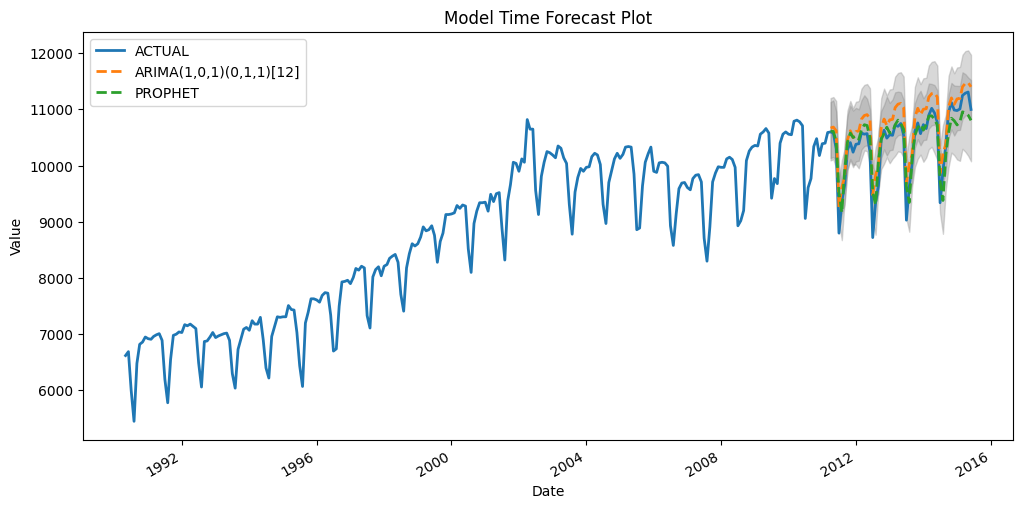

In [13]:

plot_modeltime_forecast(forecast_results_test_uni, interactive=False)  # For static plot
plot_modeltime_forecast(forecast_results_test_uni, interactive=True)   # For interactive plot

# ModelTimeRefit

In [14]:

# Initialize the refitter
refitter = ModelTimeRefit(modeltime_table_uni, verbose=True, parallel=True, max_workers=4)

# Refit the models with the new data
full_data = pd.concat([train_data, test_data], ignore_index=True)  # Replace with your entire dataset (train + test)


target_column = 'value'  # Specify the target column from your dataset
refitted_models = refitter.refit_models(full_data, target_column)


DEBUG:cmdstanpy:input tempfile: /tmp/tmprb578og2/il1oueaw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmprb578og2/pskp97a6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=83325', 'data', 'file=/tmp/tmprb578og2/il1oueaw.json', 'init=/tmp/tmprb578og2/pskp97a6.json', 'output', 'file=/tmp/tmprb578og2/prophet_modely3t8k_7f/prophet_model-20231224191036.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:10:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:10:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Model successfully refitted: <pymodeltime.ProphetReg.ProphetReg object at 0x79263d3df760>
Model successfully refitted: <pymodeltime.ArimaReg.ArimaReg object at 0x79263d411120>


In [17]:
forecast_horizon = "12 months"

forecast_future = ModelTimeForecast(modeltime_table_uni, actual_data= full_data, forecast_horizon=forecast_horizon,target_column= 'value')
forecast_results_future_uni = forecast_future.forecast()
forecast_results_future_uni.to_csv("forecast_results_future_uni.csv", index=False)

Unable to infer frequency of the date column. Defaulting to daily frequency.
Processing future predictions for model: ArimaReg
Unable to infer frequency of the date column. Defaulting to daily frequency.
Original future_data:           ds
0 2016-07-31
1 2016-08-31
2 2016-09-30
3 2016-10-31
4 2016-11-30
Processed future_data for Prophet:           ds
0 2016-07-31
1 2016-08-31
2 2016-09-30
3 2016-10-31
4 2016-11-30


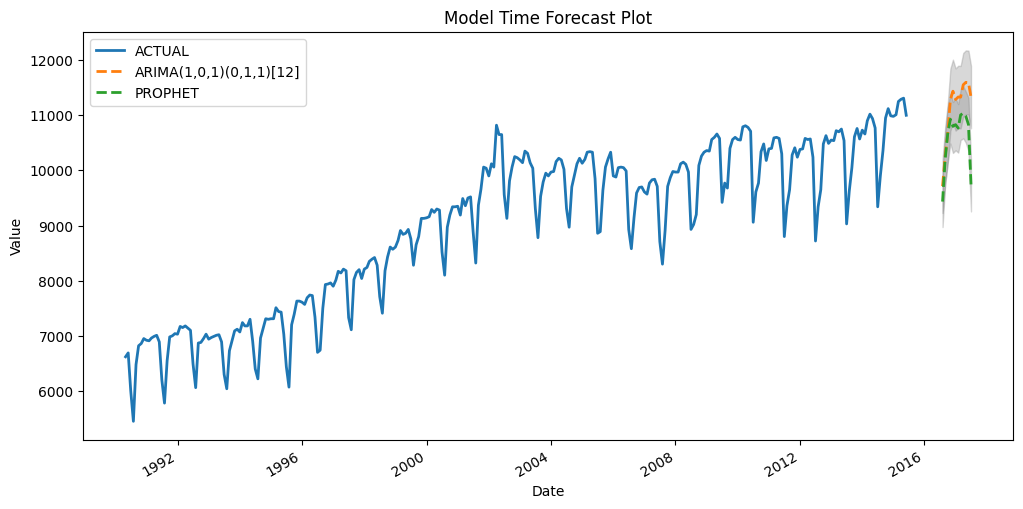

In [18]:

plot_modeltime_forecast(forecast_results_future_uni, interactive=False)  # For static plot
plot_modeltime_forecast(forecast_results_future_uni, interactive=True)   # For interactive plot